In [1]:
%%capture
!pip install torch tqdm matplotlib scikit-learn

In [2]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from mvlearn.embed import CCA
from mvlearn.plotting import crossviews_plot
from cca_zoo.deep import architectures, DCCA
from cca_zoo.deep.data import NumpyDataset, check_dataset, get_dataloaders
import pytorch_lightning as pl

## Plotting Code

### Clustering using t-SNE

In [4]:
def save_activation_projection_tsne(
    split1_activations1,
    split1_activations2,
    split2_activations1,
    split2_activations2,
    fname,
    title,
    split1_label1="Split 1 Positive Examples",
    split1_label2="Split 1 Negative Examples",
    split2_label1="Split 2 Positive Examples",
    split2_label2="Split 2 Negative Examples",
):
    """
    split1_activations1: n_samples x vector dim tensor
    split1_activations2: n_samples x vector dim tensor
    split2_activations1: n_samples x vector dim tensor
    split2_activations2: n_samples x vector dim tensor

    projects to n_samples x 2 dim tensor using t-SNE (over the full dataset of both activations 1 and 2) and saves visualization.
    Colors projected activations1 as blue and projected activations2 as red for the first split.
    Colors projected activations1 as green and projected activations2 as orange for the second split.
    """
    plt.clf()
    activations = torch.cat([split1_activations1, split1_activations2, split2_activations1, split2_activations2], dim=0)
    activations_np = activations.cpu().numpy()

    # t-SNE transformation
    tsne = TSNE(n_components=2)
    projected_activations = tsne.fit_transform(activations_np)

    # Getting back activations1 and activations2 for both splits
    indices = [
        (0, split1_activations1.shape[0]),
        (split1_activations1.shape[0], split1_activations1.shape[0] + split1_activations2.shape[0]),
        (split1_activations1.shape[0] + split1_activations2.shape[0], split1_activations1.shape[0] + split1_activations2.shape[0] + split2_activations1.shape[0]),
        (split1_activations1.shape[0] + split1_activations2.shape[0] + split2_activations1.shape[0], None)
    ]
    split1_activations1_projected = projected_activations[indices[0][0]: indices[0][1]]
    split1_activations2_projected = projected_activations[indices[1][0]: indices[1][1]]
    split2_activations1_projected = projected_activations[indices[2][0]: indices[2][1]]
    split2_activations2_projected = projected_activations[indices[3][0]: indices[3][1]]

    # Visualization for split 1
    for x, y in split1_activations1_projected:
        plt.scatter(x, y, color="blue", marker="o", alpha=0.4)

    for x, y in split1_activations2_projected:
        plt.scatter(x, y, color="red", marker="o", alpha=0.4)
        
    # Visualization for split 2
    for x, y in split2_activations1_projected:
        plt.scatter(x, y, color="green", marker="s", alpha=0.4)

    for x, y in split2_activations2_projected:
        plt.scatter(x, y, color="orange", marker="s", alpha=0.4)

    # Adding the legend
    split1_scatter1 = plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="blue",
        markersize=10,
        label=split1_label1,
    )
    split1_scatter2 = plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="red",
        markersize=10,
        label=split1_label2,
    )
    
    split2_scatter1 = plt.Line2D(
        [0],
        [0],
        marker="s",
        color="w",
        markerfacecolor="green",
        markersize=10,
        label=split2_label1,
    )
    split2_scatter2 = plt.Line2D(
        [0],
        [0],
        marker="s",
        color="w",
        markerfacecolor="orange",
        markersize=10,
        label=split2_label2,
    )

    plt.legend(handles=[split1_scatter1, split1_scatter2, split2_scatter1, split2_scatter2])
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.savefig(fname)

In [5]:
def plot_all_activations(dirpath1, dirpath2, layers):
    if not os.path.exists("../save"):
        os.mkdir("../save")
        
    for layer in layers:
        first_pos = torch.load(f"{dirpath1}/positive_layer_{layer}.pt")
        first_neg = torch.load(f"{dirpath1}/negative_layer_{layer}.pt")
        second_pos = torch.load(f"{dirpath2}/positive_layer_{layer}.pt")
        second_neg = torch.load(f"{dirpath2}/negative_layer_{layer}.pt")
        
        # reduce dimensionality using PCA
        pca_dim = min(first_pos.shape[0] + first_neg.shape[0],
                      second_pos.shape[0] + second_neg.shape[0])
        
        first_pca = PCA(n_components=pca_dim)
        first_pca.fit(torch.cat([first_pos, first_neg], dim=0))
        first_pos = torch.tensor(first_pca.transform(first_pos))
        first_neg = torch.tensor(first_pca.transform(first_neg))
        
        second_pca = PCA(n_components=pca_dim)
        second_pca.fit(torch.cat([second_pos, second_neg], dim=0))
        second_pos = torch.tensor(second_pca.transform(second_pos))
        second_neg = torch.tensor(second_pca.transform(second_neg))
        
        save_activation_projection_tsne(
            first_pos,
            first_neg,
            second_pos,
            second_neg,
            f"../save/activations_layer_{layer}.png",
            f"t-SNE projected activations layer {layer}",
            split1_label1="Split 1 Positive Examples",
            split1_label2="Split 1 Negative Examples",
            split2_label1="Split 2 Positive Examples",
            split2_label2="Split 2 Negative Examples"
        )

### Cosine Similarity

In [17]:
def plot_all_cosine_similarity(dirpath1, dirpath2, layers):
    # Stacking all steering vectors
    split1_og_vec_list, split2_og_vec_list = [], []
    for layer in layers:
        split1_vec = torch.load(f"{dirpath1}/vec_layer_{layer}.pt")
        split1_og_vec_list.append(split1_vec)    
        split2_vec = torch.load(f"{dirpath2}/vec_layer_{layer}.pt")
        split2_og_vec_list.append(split2_vec)
        
    # reduce dimensionality
    dim = min(len(split1_og_vec_list), len(split2_og_vec_list))
    print("Dim:", dim)
    split1_pca = PCA(n_components=dim)
    split1_vec_list = [torch.tensor(t) for t in split1_pca.fit_transform(split1_og_vec_list)]
    split2_pca = PCA(n_components=dim)
    split2_vec_list = [torch.tensor(t) for t in split2_pca.fit_transform(split2_og_vec_list)]
    
    # transform PCA vectors into other subspace, save
    split2_vec_using_split1_pca = split1_pca.inverse_transform(split2_vec_list)
    split1_vec_using_split2_pca = split2_pca.inverse_transform(split1_vec_list)
    for layer in layers:
        torch.save(split1_vec_using_split2_pca[layer], f"{dirpath1}/pca_vec_layer_{layer}.pt")
        torch.save(split2_vec_using_split1_pca[layer], f"{dirpath2}/pca_vec_layer_{layer}.pt")
        
    # Computing cosine similarity for each pair
    all_split1_vec = torch.stack(split1_vec_list).unsqueeze(1)
    all_split2_vec = torch.stack(split2_vec_list).unsqueeze(1)
    cosine_sim = F.cosine_similarity(all_split1_vec, all_split2_vec, dim=2).tolist()
    
    # Visualization (cosine similarity of transformed vectors of both models)
    fig, ax = plt.subplots()
    ax.plot(layers, cosine_sim, marker='o')
    ax.set_title(f"Cosine Similarity of Steering Vectors vs Layer Number\nSplit 1: {dirpath1}\nSplit 2: {dirpath2}")
    ax.set_xlabel("Layer Number")
    ax.set_ylabel("Cosine Similarity")
    ax.set_ylim([-1.05, 1.05])
    plt.tight_layout()
    plt.savefig("../save/cosine_similarity_vs_layer.png")
    plt.close(fig)
    
    # Visualization (cosine similarity of model 1 original vs transformed model 2)
    first = torch.stack(split1_og_vec_list).unsqueeze(1)
    second = torch.stack([torch.tensor(x) for x in split2_vec_using_split1_pca]).unsqueeze(1)
    cosine_sim_split1_og_split2_pca = F.cosine_similarity(first, second, dim=2).tolist()
    fig, ax = plt.subplots()
    ax.plot(layers, cosine_sim_split1_og_split2_pca, marker='o')
    ax.set_title(f"Cosine Similarity of Steering Vectors vs Layer Number\nSplit 1 OG: {dirpath1}\nSplit 2 PCA: {dirpath2}")
    ax.set_xlabel("Layer Number")
    ax.set_ylabel("Cosine Similarity")
    ax.set_ylim([-1.05, 1.05])
    plt.tight_layout()
    plt.savefig("../save/cosine_similarity_vs_layer_split1_og_split2_pca.png")
    plt.close(fig)
    
    # Visualization (cosine similarity of model 2 original vs transformed model 1)
    first = torch.stack([torch.tensor(x) for x in split1_vec_using_split2_pca]).unsqueeze(1)
    second = torch.stack(split2_og_vec_list).unsqueeze(1)
    cosine_sim_split2_og_split1_pca = F.cosine_similarity(first, second, dim=2).tolist()
    fig, ax = plt.subplots()
    ax.plot(layers, cosine_sim_split2_og_split1_pca, marker='o')
    ax.set_title(f"Cosine Similarity of Steering Vectors vs Layer Number\nSplit 1 PCA: {dirpath1}\nSplit 2 OG: {dirpath2}")
    ax.set_xlabel("Layer Number")
    ax.set_ylabel("Cosine Similarity")
    ax.set_ylim([-1.05, 1.05])
    plt.tight_layout()
    plt.savefig("../save/cosine_similarity_vs_layer_split2_og_split1_pca.png")
    plt.close(fig)

### CCA 

In [18]:
def plot_all_cca_values(train_dirpath1, train_dirpath2, dirpath1, dirpath2, layers):
    # Learning common subspace for activation vectors using CCA on training dataset
    split1_train_data_list, split2_train_data_list = [], []
    layer_cca_list = []
    for layer in layers:
        print("CCA for layer:", layer)
        first_activations = torch.cat([torch.load(f"{train_dirpath1}/positive_layer_{layer}.pt")[:2500],
                                       torch.load(f"{train_dirpath1}/negative_layer_{layer}.pt")[:2500]])
        second_activations = torch.cat([torch.load(f"{train_dirpath2}/positive_layer_{layer}.pt")[:2500],
                                        torch.load(f"{train_dirpath2}/negative_layer_{layer}.pt")[:2500]])
        # print("first_activations.shape:", first_activations.shape)
        # print("second_activations.shape:", second_activations.shape)
        dim = min(first_activations.shape[1], second_activations.shape[1], 5)
        print("Dim:", dim)
        cca = CCA(dim, regs=0.5)
        cca.fit([first_activations.numpy(), second_activations.numpy()])
        split1_train_data_list.append(first_activations.numpy())
        split2_train_data_list.append(second_activations.numpy())
        layer_cca_list.append(cca)
        
        cca_scores = cca.transform([first_activations.numpy(), second_activations.numpy()])
        fig, ax = crossviews_plot(cca_scores, equal_axes=True, scatter_kwargs={'alpha': 0.4, 's': 2.0}, show=False)
        fig.savefig(f"../save/cca_scores_layer_{layer}")
        
    # # Transforming test steering vectors into common subspace
    # split1_vec_list, split2_vec_list = [], []
    # for layer in layers:
    #     split1_vec = torch.load(f"{dirpath1}/vec_layer_{layer}.pt")
    #     split2_vec = torch.load(f"{dirpath2}/vec_layer_{layer}.pt")
    #     
    #     cca = layer_cca_list[layer]
    #     cca_split1_vec, cca_split2_vec = cca.transform([split1_vec, split2_vec])
    #     split1_vec_list.append(cca_split1_vec)
    #     split2_vec_list.append(cca_split2_vec)
    #     
    # # Computing cosine similarity for each pair
    # all_split1_vec = torch.stack(split1_vec_list).unsqueeze(1)
    # all_split2_vec = torch.stack(split2_vec_list).unsqueeze(1)
    # cosine_sim = F.cosine_similarity(all_split1_vec, all_split2_vec, dim=2).tolist()
    # 
    # # Visualization 
    # plt.plot(layers, cosine_sim, marker='o')
    # plt.title(f"Cosine Similarity of CCA Steering Vectors vs Layer Number\nSplit 1: {dirpath1}\nSplit 2: {dirpath2}")
    # plt.xlabel("Layer Number")
    # plt.ylabel("Cosine Similarity")
    # plt.ylim([-1.05, 1.05])
    # plt.tight_layout()
    # plt.savefig("../save/cca_cosine_similarity_vs_layer.png")

### DCCA

In [18]:
def plot_all_dcca_values(train_dirpath1, train_dirpath2, dirpath1, dirpath2, layers):
    # Learning common subspace for activation vectors using DCCA
    layer_dcca_list = []
    for layer in layers:
        print("DCCA for layer:", layer)
        first_activations = torch.cat([torch.load(f"{train_dirpath1}/positive_layer_{layer}.pt")[:5000],
                                       torch.load(f"{train_dirpath1}/negative_layer_{layer}.pt")[:5000]])
        second_activations = torch.cat([torch.load(f"{train_dirpath2}/positive_layer_{layer}.pt")[:5000],
                                        torch.load(f"{train_dirpath2}/negative_layer_{layer}.pt")[:5000]])
        
        assert np.isnan(first_activations).any() == False
        assert np.isnan(second_activations).any() == False
        
        # Define DCCA model
        dim = min(first_activations.shape[1], second_activations.shape[1], 25)
        first_encoder = architectures.Encoder(latent_dimensions=dim, feature_size=first_activations.shape[1])
        second_encoder = architectures.Encoder(latent_dimensions=dim, feature_size=second_activations.shape[1])
        dcca_model = DCCA(latent_dimensions=dim, encoders=[first_encoder, second_encoder])
        
        # Train DCCA model
        first_activations_train_dataset, first_activations_val_dataset = train_test_split(first_activations.numpy(), 
                                                                                          test_size=0.33,
                                                                                          shuffle=True)
        second_activations_train_dataset, second_activations_val_dataset = train_test_split(second_activations.numpy(), 
                                                                                            test_size=0.33,
                                                                                            shuffle=True)
        activations_train_dataset = NumpyDataset([first_activations_train_dataset, second_activations_train_dataset])
        activations_val_dataset = NumpyDataset([first_activations_val_dataset, second_activations_val_dataset])
        train_loader = get_dataloaders(activations_train_dataset, batch_size=256)
        val_loader = get_dataloaders(activations_val_dataset, batch_size=256)
        epochs = 50
        trainer = pl.Trainer(
            accelerator="cpu",
            max_epochs=epochs,
            enable_checkpointing=False,
            enable_model_summary=False,
            enable_progress_bar=True,
        )
        trainer.fit(dcca_model, train_dataloaders=train_loader)
        trainer.test(dcca_model, dataloaders=val_loader)
        layer_dcca_list.append(dcca_model)
        
    # Transforming steering vectors into learnt subspace
    split1_vec_list, split2_vec_list = [], []
    for layer in layers:
        split1_vec = torch.load(f"{dirpath1}/vec_layer_{layer}.pt")
        split2_vec = torch.load(f"{dirpath2}/vec_layer_{layer}.pt")
        
        dcca_model = layer_dcca_list[layer]
        dcca_split1_vec, dcca_split2_vec = dcca_model([split1_vec, split2_vec])
        split1_vec_list.append(dcca_split1_vec)
        split2_vec_list.append(dcca_split2_vec)
        
    # Computing cosine similarity for each pair
    all_split1_vec = torch.stack(split1_vec_list).unsqueeze(1)
    all_split2_vec = torch.stack(split2_vec_list).unsqueeze(1)
    cosine_sim = F.cosine_similarity(all_split1_vec, all_split2_vec, dim=2).tolist()
    
    # Visualization 
    plt.plot(layers, cosine_sim, marker='o')
    plt.title(f"Cosine Similarity of DCCA Steering Vectors vs Layer Number\nSplit 1: {dirpath1}\nSplit 2: {dirpath2}")
    plt.xlabel("Layer Number")
    plt.ylabel("Cosine Similarity")
    plt.ylim([-1.05, 1.05])
    plt.tight_layout()
    plt.savefig("../save/dcca_cosine_similarity_vs_layer.png")

### DCCA (from scratch)

In [ ]:
def plot_all_dcca_from_scratch_values(train_dirpath1, train_dirpath2, dirpath1, dirpath2, layers):
    # Learning common subspace for activation vectors using DCCA from scratch
    layer_dcca_list = []
    for layer in layers:
        print("DCCA from scratch for layer:", layer)
        first_activations = torch.cat([torch.load(f"{train_dirpath1}/positive_layer_{layer}.pt")[:5000],
                                       torch.load(f"{train_dirpath1}/negative_layer_{layer}.pt")[:5000]])
        second_activations = torch.cat([torch.load(f"{train_dirpath2}/positive_layer_{layer}.pt")[:5000],
                                        torch.load(f"{train_dirpath2}/negative_layer_{layer}.pt")[:5000]])
        
        assert np.isnan(first_activations).any() == False
        assert np.isnan(second_activations).any() == False
        
        # Define DCCA model from scratch
        dim = min(first_activations.shape[1], second_activations.shape[1], 25)
        first_encoder = architectures.Encoder(latent_dimensions=dim, feature_size=first_activations.shape[1])
        second_encoder = architectures.Encoder(latent_dimensions=dim, feature_size=second_activations.shape[1])
        dcca_model = DCCA(latent_dimensions=dim, encoders=[first_encoder, second_encoder])
        
        # Train DCCA model
        first_activations_train_dataset, first_activations_val_dataset = train_test_split(first_activations.numpy(), 
                                                                                          test_size=0.33,
                                                                                          shuffle=True)
        second_activations_train_dataset, second_activations_val_dataset = train_test_split(second_activations.numpy(), 
                                                                                            test_size=0.33,
                                                                                            shuffle=True)
        activations_train_dataset = NumpyDataset([first_activations_train_dataset, second_activations_train_dataset])
        activations_val_dataset = NumpyDataset([first_activations_val_dataset, second_activations_val_dataset])
        train_loader = get_dataloaders(activations_train_dataset, batch_size=256)
        val_loader = get_dataloaders(activations_val_dataset, batch_size=256)
        epochs = 50
        trainer = pl.Trainer(
            accelerator="cpu",
            max_epochs=epochs,
            enable_checkpointing=False,
            enable_model_summary=False,
            enable_progress_bar=True,
        )
        trainer.fit(dcca_model, train_dataloaders=train_loader)
        trainer.test(dcca_model, dataloaders=val_loader)
        layer_dcca_list.append(dcca_model)
        
    # Transforming steering vectors into learnt subspace
    split1_vec_list, split2_vec_list = [], []
    for layer in layers:
        split1_vec = torch.load(f"{dirpath1}/vec_layer_{layer}.pt")
        split2_vec = torch.load(f"{dirpath2}/vec_layer_{layer}.pt")
        
        dcca_model = layer_dcca_list[layer]
        dcca_split1_vec, dcca_split2_vec = dcca_model([split1_vec, split2_vec])
        split1_vec_list.append(dcca_split1_vec)
        split2_vec_list.append(dcca_split2_vec)
        
    # Computing cosine similarity for each pair
    all_split1_vec = torch.stack(split1_vec_list).unsqueeze(1)
    all_split2_vec = torch.stack(split2_vec_list).unsqueeze(1)
    cosine_sim = F.cosine_similarity(all_split1_vec, all_split2_vec, dim=2).tolist()
    
    # Visualization 
    plt.plot(layers, cosine_sim, marker='o')
    
    plt.title(f"Cosine Similarity of DCCA Steering Vectors vs Layer Number\nSplit 1: {dirpath1}\nSplit 2: {dirpath2}")
    plt.xlabel("Layer Number")
    plt.ylabel("Cosine Similarity")
    plt.ylim([-1.05, 1.05])
    plt.tight_layout()
    plt.savefig("../save/dcca_cosine_similarity_vs_layer.png")

## Run

In [19]:
first_dirpath = "../save/llama_7b_chat_refusal_data_A_B_exp_data"
train_first_dirpath = "../save/llama_7b_chat_more_qa_data_A_B_exp_data"
second_dirpath = "../save/llama_13b_chat_refusal_data_A_B_exp_data"
train_second_dirpath = "../save/llama_13b_chat_more_qa_data_A_B_exp_data"
start_layer = 0
end_layer = 31
layer_numbers = list(range(start_layer, end_layer + 1))

In [9]:
# plot_all_activations(first_dirpath, second_dirpath, layer_numbers)

In [18]:
# plot_all_cosine_similarity(first_dirpath, second_dirpath, layer_numbers)

Dim: 32


CCA for layer: 21
Dim: 5


IndexError: list index out of range

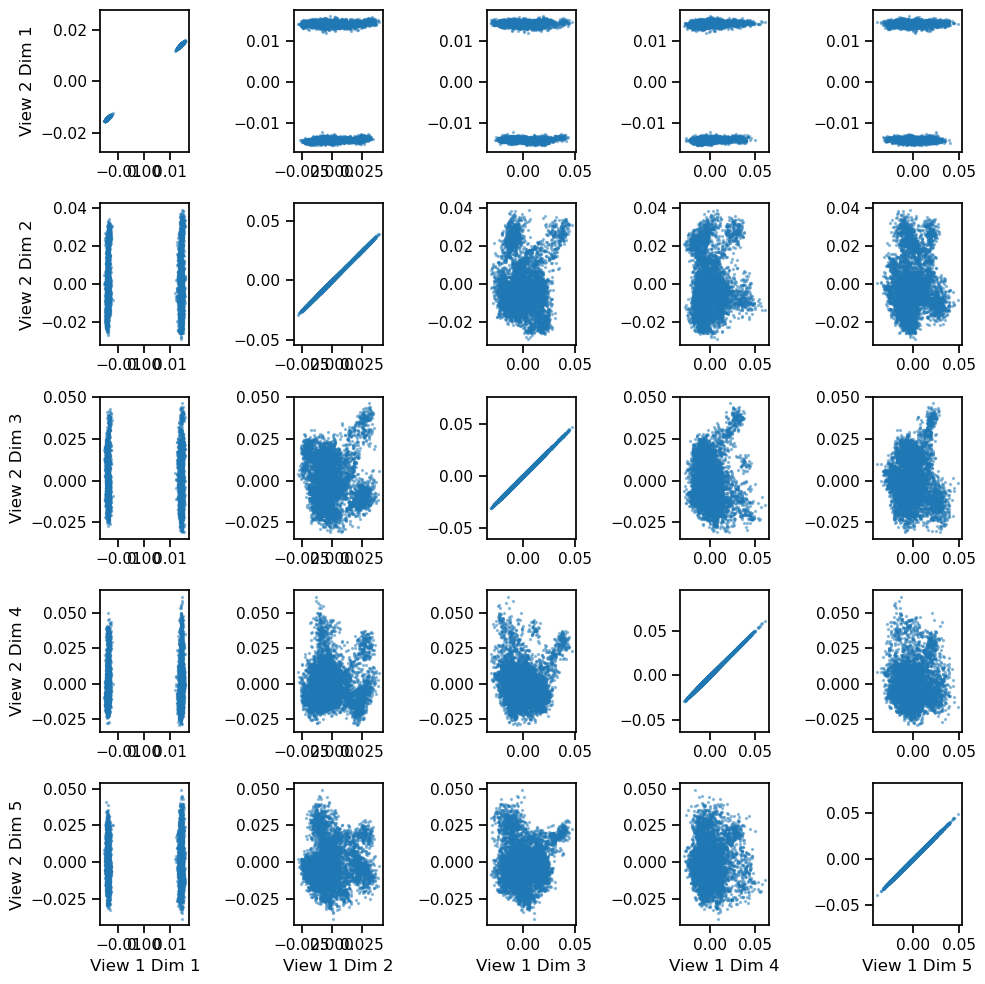

In [17]:
plot_all_cca_values(train_first_dirpath, train_second_dirpath, first_dirpath, second_dirpath, layer_numbers)

In [ ]:
plot_all_dcca_values(train_first_dirpath, train_second_dirpath, first_dirpath, second_dirpath, layer_numbers)